# Main

This file contains everything you need to run the model. This requires already be in csv format in the "data/clean" directory.

You must run everything in "scripts" before running this file.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm

## Visualize paths

This just defines the funciton for the visualization.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output
import glob
import os

%matplotlib widget

def create_interactive_3d_plot(root="data/clean", x="tx", y="ty", z="tz"):

    dirs = os.listdir(root)

    directory_dropdown = widgets.Dropdown(
        options=dirs,
        description="Select Directory:",
        disabled=False
    )

    # Get a list of all CSV files in the specified directory
    csv_files = os.listdir(os.path.join(root, dirs[0]))
    if not csv_files:
        print(f"No CSV files found in {os.path.abspath(root)}")
        return

    # Create a dropdown widget for file selection
    file_dropdown = widgets.Dropdown(
        options=csv_files,
        description="Select CSV:",
        disabled=False,
    )

    output_area = widgets.Output()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    def update_files(change):
        with output_area:
            clear_output(wait=True)
            selected_directory = change["new"]
            new_files = os.listdir(os.path.join(root, selected_directory))

            if new_files:
                file_dropdown.options = new_files
                file_dropdown.disabled = False
            else:
                file_dropdown.options = ["No files"]
                file_dropdown.disabled = True

    def update_plot(change):
        with output_area:
            clear_output(wait=True)
            selected_file = change["new"]
            selected_directory = directory_dropdown.value
            
            file_path = os.path.join(root, selected_directory, selected_file)
            ax.clear()
            
            try:
                df = pd.read_csv(file_path)

                if x not in df.columns or y not in df.columns or z not in df.columns:
                    ax.clear() # Clear any previous plot or error message
                    ax.text2D(0.5, 0.5, f"Error: '{file_path}' missing '{x}', '{y}', or '{z}' columns.", # type: ignore
                            transform=ax.transAxes, ha="center")
                    fig.canvas.draw_idle()
                    return

                ax.clear()

                line = ax.plot(df[x], df[y], df[z])[0]

                # Update labels and title
                ax.set_xlabel("X-axis")
                ax.set_ylabel("Y-axis")
                ax.set_zlabel("Z-axis")
                ax.set_title(f"3D Line Plot: {file_path}")

                # Ensure data limits are set correctly for the new data
                x_min, x_max = df[x].min(), df[x].max()
                y_min, y_max = df[y].min(), df[y].max()
                z_min, z_max = df[z].min(), df[z].max()

                # Add a small buffer to the limits for better visualization
                x_buffer = (x_max - x_min) * 0.05
                y_buffer = (y_max - y_min) * 0.05
                z_buffer = (z_max - z_min) * 0.05

                ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
                ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
                ax.set_zlim(z_min - z_buffer, z_max + z_buffer)

                
            except Exception as e:
                ax.clear() # Clear any previous plot or error message
                ax.text2D(0.5, 0.5, f"Error loading or plotting {file_path}: {e}", # type: ignore
                        transform=ax.transAxes, ha="center")
                fig.canvas.draw_idle()



    directory_dropdown.observe(update_files, names="value")
    file_dropdown.observe(update_plot, names="value")

    display(widgets.VBox([directory_dropdown, file_dropdown, output_area]))

    update_files({"new": directory_dropdown.value})
    update_plot({"new": file_dropdown.value})
    
    plt.show()

## Resample the data and derive velocity and acceleration

The fpv-uzh and mid-air datasets have different sample rates and formats. This code is meant to resample everything to 10hz (sample time = 0.1sec). It does this via block means as a simple noise reduction method. More sophisticated noise reduction techniques need to be explored later.

The sample rate is can actually be thought of as a hyperparameter for our model. For now, we are following the VECTOR GRU paper.

The model can either be trained on positional, velocity, or acceleration data.

At the moment, the acceleration data seems to be too noisy to be useful.

In [4]:
def resample(df: pd.DataFrame, sampling_time: float):
    """
    This function takes the block average as a simple way to reduce noise
    """
    df = df.sort_values("timestamp")
    bins = np.arange(
        df['timestamp'].min(), 
        df['timestamp'].max() + sampling_time + 1e-9, 
        sampling_time
    )
    
    df["bin_index"] = np.digitize(df["timestamp"], bins, right=True)

    grouped = df.groupby("bin_index")
    mean_values = grouped[["tx", "ty", "tz"]].mean()

    unique_grouped_indices = mean_values.index.values

    valid_indices_mask = unique_grouped_indices > 0
    
    filtered_bin_indices = unique_grouped_indices[valid_indices_mask]
    filtered_mean_values = mean_values[valid_indices_mask]

    df_resampled = pd.DataFrame({
        # For a bin_index 'k', the block starts at bins[k-1]
        'timestamp': bins[filtered_bin_indices - 1],
        'tx': filtered_mean_values["tx"].values,
        'ty': filtered_mean_values["ty"].values,
        'tz': filtered_mean_values["tz"].values
    })
    
    return df_resampled

def velocity(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "vx", "vy", "vz"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["vx"] = df["tx"].diff() / dt
    out["vy"] = df["ty"].diff() / dt
    out["vz"] = df["tz"].diff() / dt

    return out.iloc[1:]

def acceleration(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "ax", "ay", "az"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["ax"] = df["vx"].diff() / dt
    out["ay"] = df["vy"].diff() / dt
    out["az"] = df["vz"].diff() / dt

    return out.iloc[1:]

# resample everything in "data/clean" and save positional and velocity data.
out_path_pos = "data/position/raw"
out_path_vel = "data/velocity/raw"
out_path_acc = "data/acceleration/raw"
os.makedirs(out_path_pos, exist_ok=True)
os.makedirs(out_path_vel, exist_ok=True)
os.makedirs(out_path_acc, exist_ok=True)

def walk_and_process(root="data/clean"):
    for dirname in os.listdir(root):
        os.makedirs(os.path.join(out_path_pos, dirname), exist_ok=True)
        os.makedirs(os.path.join(out_path_vel, dirname), exist_ok=True)
        os.makedirs(os.path.join(out_path_acc, dirname), exist_ok=True)
        for filename in os.listdir(os.path.join(root, dirname)):
            df = pd.read_csv(os.path.join(root, dirname, filename))
            pos = resample(df, 0.1)
            vel = velocity(pos)
            acc = acceleration(vel)
            pos.to_csv(os.path.join(out_path_pos, dirname, filename))
            vel.to_csv(os.path.join(out_path_vel, dirname, filename))
            acc.to_csv(os.path.join(out_path_acc, dirname, filename))
    
 
walk_and_process()

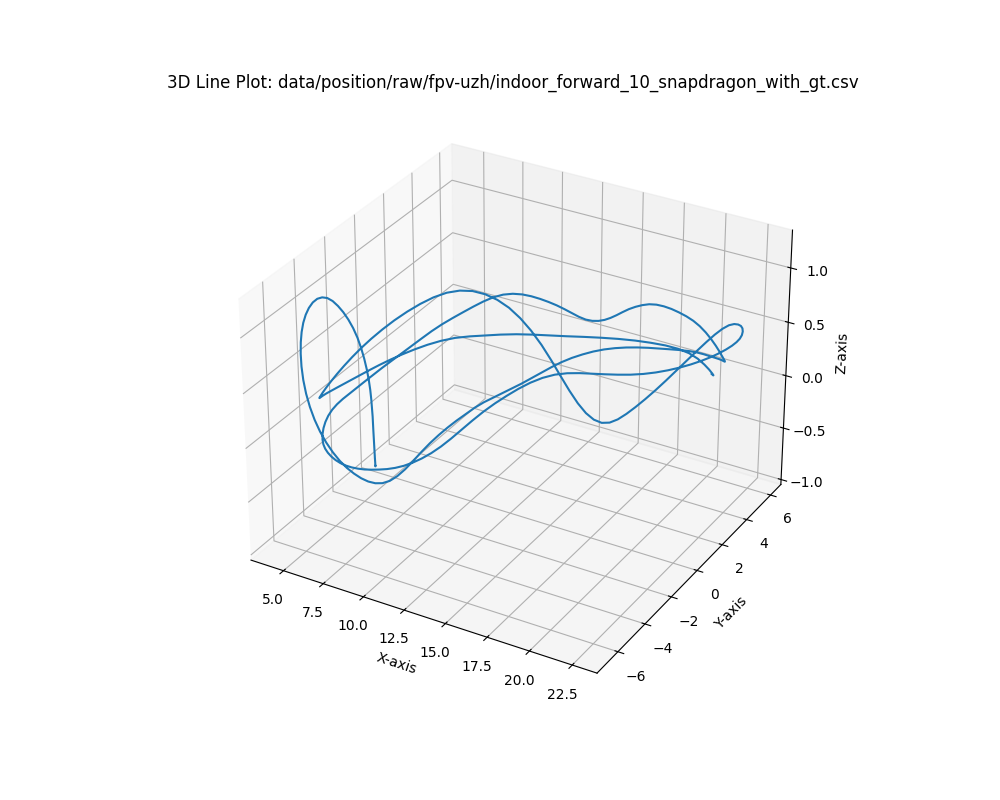

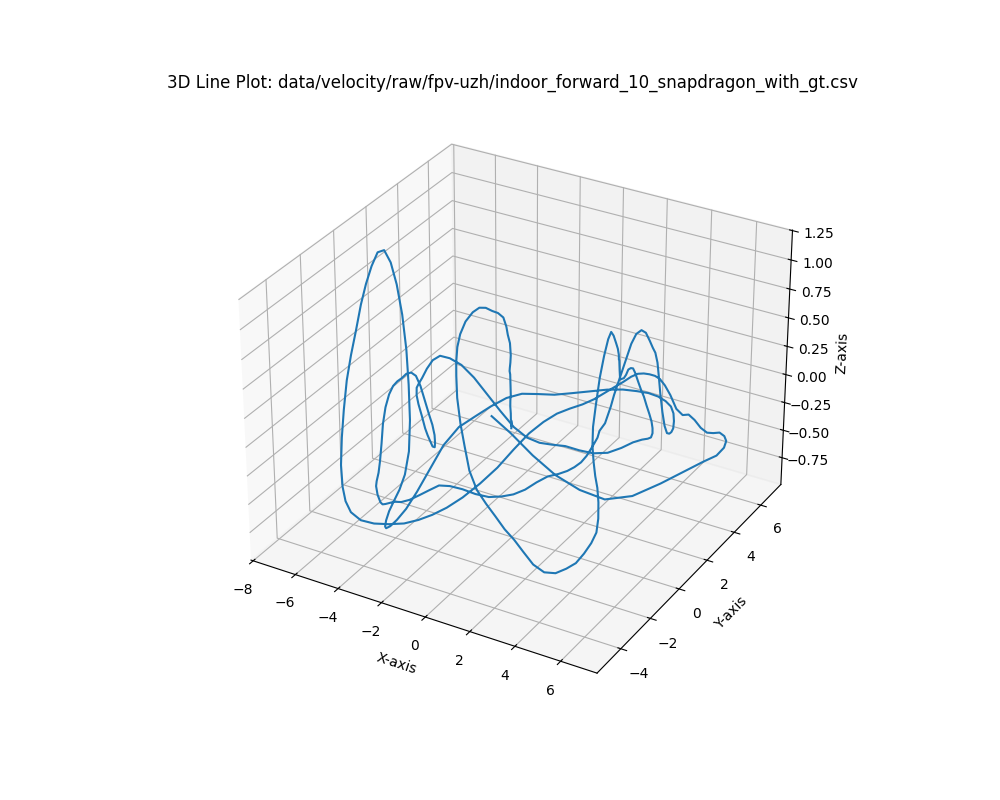

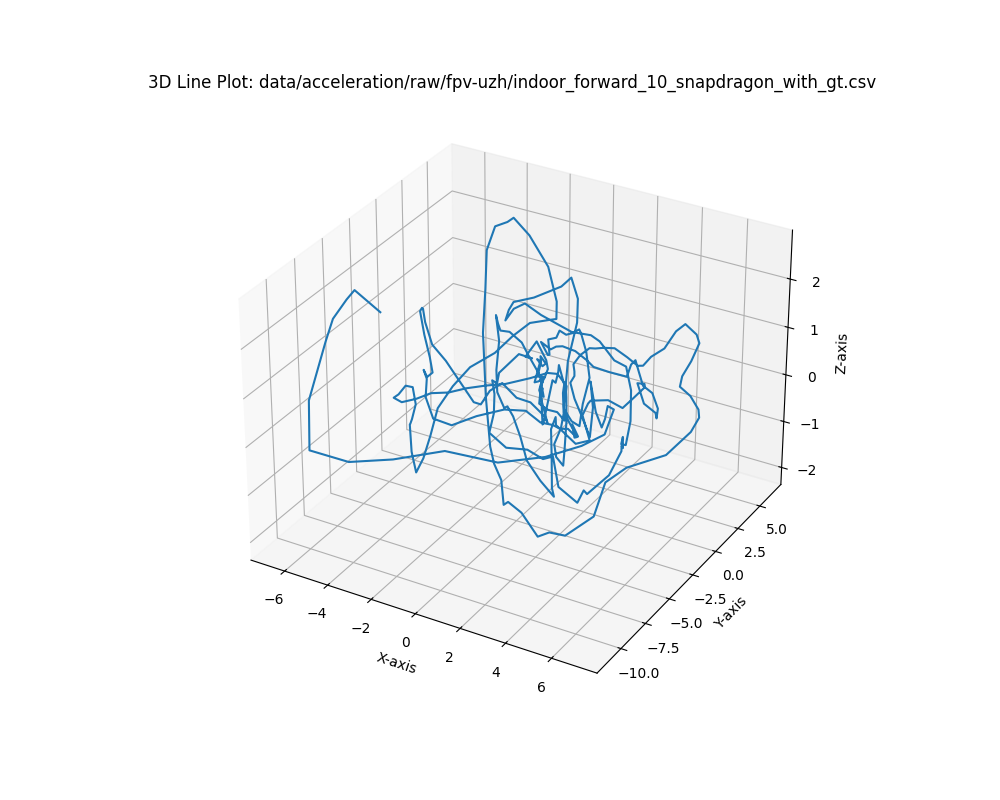

In [5]:
# TODO: consolidate into one widget so the selection displays all 3
create_interactive_3d_plot(root=out_path_pos, x="tx", y="ty", z="tz")
create_interactive_3d_plot(root=out_path_vel, x="vx", y="vy", z="vz")

# NOTE: Seems like as you take the derivative, the paths get more erradict. 
# This could show that the higher order derivatives have more entropy in the signal,
# and thus have higher information content. 
# A tradeoff is that as you take higher order numerical derivatives, noise builds up.
create_interactive_3d_plot(root=out_path_acc, x="ax", y="ay", z="az")

### Observations

The data collected from actual flights seem to be "nicer" to take the numerical derivative of.

Furthermore, the actual data sources provide direct access to IMU measurements. 

## Normalize Data

We will use max normalization and statistical whitening

I want to explore local normalization

## Split data

5-fold stratified cross validation. Must be stratified because training data comes from different distributions.

In [ ]:
from math import floor
import random
from typing import TypedDict


class Fold(TypedDict):
    train: list[str]
    validation: list[str]
    test: list[str]
        
root = "data/position/raw"
strata = os.listdir(root)
k: int = 5
shuffle = False

folds: list[Fold] = [
    {"train": [], "validation": [], "test": []}
    for _ in range(k)
]
# Assume all csv's have unique names
for stratum in strata:
    files = os.listdir(os.path.join(root, stratum))
    if shuffle:
        random.shuffle(files)

    m = len(files)
    
    for i in range(k):
        fold_start = floor(m * (i/k))
        fold_end = floor(m * ((i+1)/k))
        
        fold = files[fold_start:fold_end]

        fold_train = floor(len(fold) * 0.65)
        fold_validation = floor(len(fold) * 0.85)

        folds[i]["train"].extend([os.path.join(root, stratum, f) for f in fold[0 : fold_train]])
        folds[i]["validation"].extend([os.path.join(root, stratum, f) for f in fold[fold_train : fold_validation]])
        folds[i]["test"].extend([os.path.join(root, stratum, f) for  f in fold[fold_validation :]])

### This class defines our custom trajectory dataset

I optimized it in the most practical way, balancing ram usage and conversion overheads.

In [14]:
class TrajectoryDataset(torch.utils.data.Dataset):

    def __init__(self, files: list[str], input_length: int, output_length: int):
        self.input_length = input_length
        self.output_length = output_length
        self.total_sequence_length = input_length + output_length

        self.sample_map: list[tuple[int, int, int]] = []
        
        self.data_arrays: list[np.ndarray] = [] 
        
        current_global_index = 0

        for df_idx, file in enumerate(files):
            try:
                df: pd.DataFrame = pd.read_csv(file, usecols=["tx", "ty", "tz"])
            except Exception as e:
                print(f"Error reading {file}: {e}. Skipping.")
                continue

            numeric_cols = df.select_dtypes(include=['number']).columns
            if numeric_cols.empty:
                print(f"{file} has no numeric columns. Skipping.")
                continue
            
            data_array = df[numeric_cols].values.astype(np.float32) # Ensure float32 here
            
            if len(data_array) < self.total_sequence_length:
                print(f"{file} is too short ({len(data_array)} rows) for input_length={input_length} and output_length={output_length}. Skipping.")
                continue
            
            num_sequences_in_df = len(data_array) - self.total_sequence_length + 1
            
            for i in range(num_sequences_in_df):
                self.sample_map.append((current_global_index + i, df_idx, i))
            
            current_global_index += num_sequences_in_df
            self.data_arrays.append(data_array) # Store the NumPy array

        self.total_samples = current_global_index

    def __len__(self) -> int:
        return self.total_samples

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        if not (0 <= index < self.total_samples):
            raise IndexError(f"Index {index} is out of bounds for dataset of size {self.total_samples}")

        global_index, df_idx, local_start_row = self.sample_map[index]

        data_array = self.data_arrays[df_idx] # Retrieve NumPy array

        x_start_local = local_start_row
        x_end_local = local_start_row + self.input_length

        y_start_local = x_end_local
        y_end_local = y_start_local + self.output_length
        
        # Slice NumPy arrays (very fast)
        x_data = data_array[x_start_local:x_end_local]
        y_data = data_array[y_start_local:y_end_local]
        
        # Convert slices to PyTorch tensors (still happens in __getitem__, but from NumPy)
        # This conversion is very efficient from NumPy arrays
        x_tensor = torch.from_numpy(x_data) 
        y_tensor = torch.from_numpy(y_data)
        
        return x_tensor, y_tensor

### Our Model

Currently a basic GRU encoder-decoder.

In [12]:
import torch
import torch.nn as nn

class TrajectoryPredictor(nn.Module):
    """
    An Encoder-Decoder model for trajectory prediction using GRU units.
    It takes an input sequence of points and predicts a future sequence of points.
    """
    def __init__(self, 
                 input_features_dim: int, 
                 hidden_state_dim: int, 
                 output_features_dim: int, 
                 num_gru_layers: int,
                 prediction_sequence_length: int): # Added explicit argument for prediction length
        """
        Initializes the TrajectoryPredictor model.

        Args:
            input_features_dim (int): The number of features in each input time step
                                      (e.g., 2 for (x,y) coordinates).
            hidden_state_dim (int): The number of features in the hidden state of the GRU layers.
                                    This also determines the dimensionality of the context vector.
            output_features_dim (int): The number of features to predict at each output time step.
                                       (e.g., 2 for (x,y) coordinates).
            num_gru_layers (int): The number of stacked GRU layers for both encoder and decoder.
            prediction_sequence_length (int): The fixed number of future time steps to predict.
        """
        super().__init__() # Cleaner way to call super() in Python 3+

        # Store important dimensions and lengths for use in forward pass
        self.hidden_state_dim = hidden_state_dim
        self.num_gru_layers = num_gru_layers
        self.prediction_sequence_length = prediction_sequence_length
        self.output_features_dim = output_features_dim # Added for clarity, though not directly used in forward for dimensions

        # Encoder GRU: Processes the input sequence
        # Takes input_features_dim at each step, outputs hidden_state_dim to its hidden state
        self.encoder_gru = nn.GRU(input_features_dim, hidden_state_dim, num_gru_layers, batch_first=True)
        
        # Decoder GRU: Generates the output sequence
        # Takes hidden_state_dim as input (from 'dummy' input or attention),
        # uses encoder's final hidden state as initial hidden state.
        self.decoder_gru = nn.GRU(hidden_state_dim, hidden_state_dim, num_gru_layers, batch_first=True)
        
        # Output layer: Projects the decoder's hidden states to the desired output dimensions
        self.output_projection_layer = nn.Linear(hidden_state_dim, output_features_dim)

    def forward(self, input_sequence: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the TrajectoryPredictor.

        Args:
            input_sequence (torch.Tensor): The input trajectory sequence.
                                           Expected shape: (batch_size, input_seq_len, input_features_dim)

        Returns:
            torch.Tensor: The predicted future trajectory sequence.
                          Expected shape: (batch_size, prediction_sequence_length, output_features_dim)
        """
        # Ensure input_sequence is on the correct device for operations
        device = input_sequence.device

        # 1. Encoder Step: Process the input_sequence
        # encoder_outputs: (batch_size, input_seq_len, hidden_state_dim) - detailed outputs at each step (often discarded)
        # encoder_final_hidden_state: (num_gru_layers, batch_size, hidden_state_dim) - The context vector
        encoder_outputs, encoder_final_hidden_state = self.encoder_gru(input_sequence) 

        # 2. Prepare Decoder's Initial Input Sequence
        # The decoder needs an input at each step to "unroll". Here, we provide a sequence of zeros.
        # The feature dimension of this dummy input must match the decoder_gru's input_size (which is hidden_state_dim).
        # We use self.prediction_sequence_length to dynamically set the sequence length.
        decoder_input_sequence = torch.zeros(
            input_sequence.size(0), # Batch size
            self.prediction_sequence_length, # Length of sequence to predict
            self.hidden_state_dim # Feature dimension for the decoder's input
        ).to(device) # Ensure it's on the same device as the input

        # 3. Decoder Step: Generate the predicted sequence
        # The encoder's final hidden state is used as the decoder's initial hidden state.
        # decoder_outputs: (batch_size, prediction_sequence_length, hidden_state_dim)
        # decoder_final_hidden_state: (num_gru_layers, batch_size, hidden_state_dim) - (often discarded if only sequence outputs needed)
        decoder_outputs, _ = self.decoder_gru(decoder_input_sequence, encoder_final_hidden_state) 

        # 4. Output Projection: Map decoder's hidden states to desired output features
        # projected_outputs: (batch_size, prediction_sequence_length, output_features_dim)
        predicted_trajectory = self.output_projection_layer(decoder_outputs) 
        
        return predicted_trajectory

### Basic training

Actual training will happen in another script due to limitations of slurm.

In [21]:
from datetime import datetime


fold = folds[0]

X_len, y_len = 20, 10
train_dataset = TrajectoryDataset(fold['train'], X_len, y_len)
validation_dataset = TrajectoryDataset(fold['validation'], X_len, y_len)
test_dataset = TrajectoryDataset(fold['test'], X_len, y_len)

train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

model = TrajectoryPredictor(
    input_features_dim=3,
    hidden_state_dim=24,
    output_features_dim=3,
    num_gru_layers=8,
    prediction_sequence_length=y_len
)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(train_loader), "train_dataset"):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

        try:
            if running_loss < 20:
                print("saving model", model_path)
                torch.save(model.state_dict(), os.path.join(save_dir, model_path))
        except Exception:
            print("failed to save")

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

save_dir = "best_models"
os.makedirs(save_dir, exist_ok=True)

for epoch in tqdm(range(EPOCHS), "epoch"):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(timestamp, 'LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        try:
            print("saving model", model_path)
            torch.save(model.state_dict(), os.path.join(save_dir, model_path))
        except Exception:
            print("failed to save")

    epoch_number += 1

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train_dataset: 0it [00:00, ?it/s]

saving model best_models
saving model best_models
saving model best_models
  batch 1000 loss: 236.57532986450195
saving model best_models
  batch 2000 loss: 386.2324433479309
saving model best_models
  batch 3000 loss: 344.2467329535484
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
  batch 4000 loss: 156.7173990483284
saving model best_models
  batch 5000 loss: 107.7505361328125
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
saving model best_models
  batch 6000 loss: 68.40472950176894
saving model best_models
saving model best_models
saving model best_models
sa

KeyboardInterrupt: 